# ESCO Skill-Occupation Matrix Tables <-> ILO Scenarios
Felix Zaussinger, 14.05.2021

## Core Analysis Goal(s)
1. Match ESCO Skill-Occupation Matrix Tables (1.2, 2.2, 3.2) to ILO green
transition scenarios to project skill demand at an aggregate level

## Key Insight(s)
1. Matching is rather straightforward. As one possible method, changes in the
demand for certain skill groups may be approximated by multiplying occupational
skill importance weights by net employment change. This creates a crude numeric
equivalence between employment change and skill demand change. To be seen if
this constitutes a viable way forward.

In [15]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper")
# sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define directory structure

In [181]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

Read ILO green transition scenario data

In [95]:
fpath_ilo = os.path.join(data_raw, "ilo_scenarios", "ilo_empl_scenarios_2030.xlsx")

ilo_scenarios = ["energy_sustainability", "circular_economy"]
df_ilo = pd.read_excel(
    io=fpath_ilo,
    sheet_name=ilo_scenarios
)

# convert to millions and calculate net employment change
scale_factor = 1000
numeric_cols = ['new_jobs_absorbing', 'new_jobs_net', 'jobs_lost_net', 'jobs_lost_reallocated']

for ilo_scenario in ilo_scenarios:
    df_ilo[ilo_scenario][numeric_cols] *= scale_factor
    df_ilo[ilo_scenario]["net_change"] = df_ilo[ilo_scenario].new_jobs_net + df_ilo[ilo_scenario].jobs_lost_net

Text(0.5, 1.0, 'circular_economy')

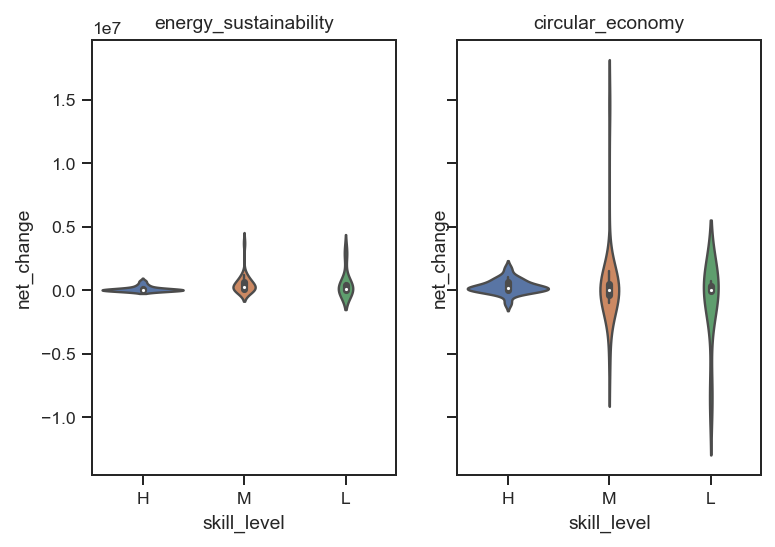

In [98]:
fig, axes = plt.subplots(ncols=2, sharey=True)

sns.violinplot(
    x="skill_level",
    y="net_change",
    data=df_ilo["energy_sustainability"],
    ax=axes[0]
).set_title("energy_sustainability")

sns.violinplot(
    x="skill_level",
    y="net_change",
    data=df_ilo["circular_economy"],
    ax=axes[1]
).set_title("circular_economy")

Read ESCO skills-occupation matrix tables

In [163]:
fpath_esco = os.path.join(data_raw, "esco", "en_Skills_Occupations Matrix Tables.xlsx")

sheet_names = ["Matrix 1.2", "Matrix 2.2", "Matrix 3.2"]

df_esco = pd.read_excel(
    io=fpath_esco,
    sheet_name=sheet_names,
    header=1
)

# name unnamed cols
for sheet_name in sheet_names:
    df_esco[sheet_name].rename(columns={'Unnamed: 0': "uri", 'Unnamed: 1': "occupation"}, errors="raise", inplace=True)

# extract isco codes and add as column
isco_codes_raw = df_esco["Matrix 1.2"].iloc[:,0].str.split("/", expand=True)
isco_codes_clean = isco_codes_raw.iloc[:, 5].str.replace("C", "")

for sheet_name in sheet_names:
    df_esco[sheet_name].insert(0, "isco_code", pd.to_numeric(isco_codes_clean))

### Join ILO data to ESCO matrix.

Visualisation test 1: multiply skill group weights by net employment change to obtain a proxy of skill demand change

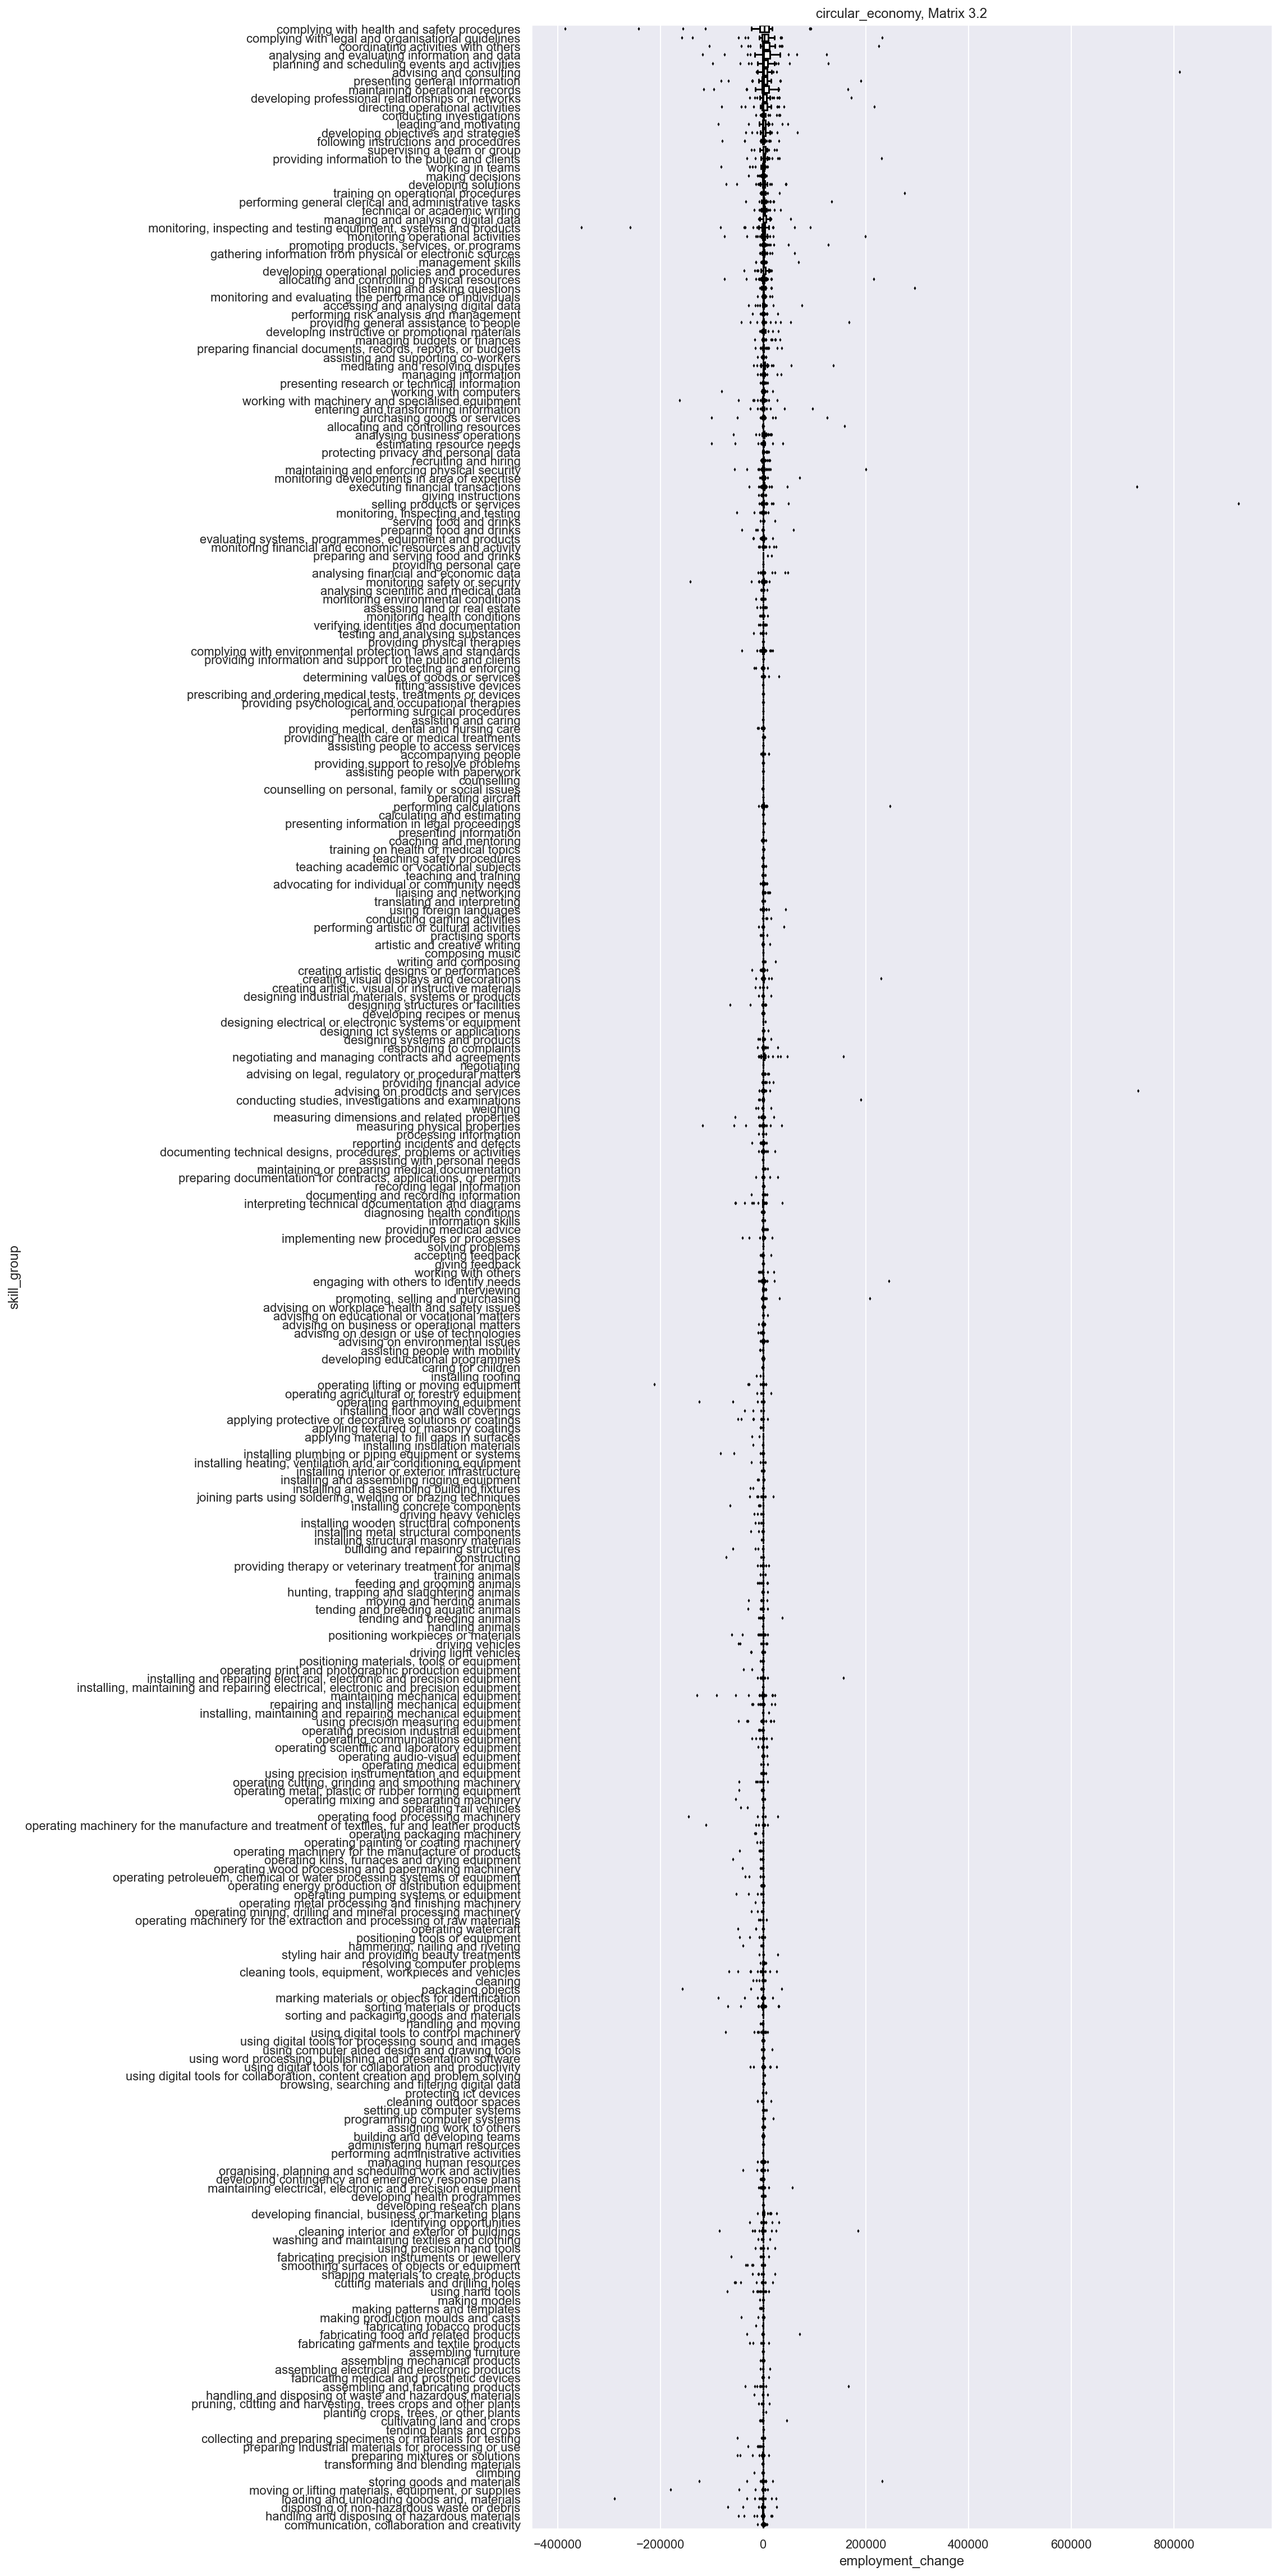

In [196]:
sns.set(rc={'figure.figsize': (16, 32.)})

# data selection
scenario = "circular_economy"  # circular_economy, energy_sustainability
esco_matrix = "Matrix 3.2"

# check if all weights sum up to 1
df_esco[esco_matrix].iloc[:,3:].sum(axis=1).all()

# extract skill groups
skill_groups = list(df_esco[esco_matrix].columns[3:].values)

# merge ILO and ESCO data
esco_ilo_es = pd.merge(
    left=df_esco[esco_matrix],
    right=df_ilo[scenario],
    on="isco_code",
    how="left",
    validate="one_to_one"
).dropna(subset=numeric_cols, how="all")

# estimate skill-group share of net employment change as a proxy for skill
# demand change
skill_demand_change = esco_ilo_es[skill_groups].multiply(esco_ilo_es["net_change"], axis=0)

# wide to long
skill_demand_change_long = skill_demand_change.melt(var_name="skill_group", value_name="employment_change")

# plot
title = "{}, {}".format(scenario, esco_matrix)
sns.boxplot(
    y="skill_group",
    x="employment_change",
    orient="h",
    fliersize=1,
    palette="binary",
    order=list(skill_demand_change.median().sort_values(ascending=False).index.values),
    data=skill_demand_change_long
).set_title(title)

# save plot
plt.tight_layout()
plt.savefig(
    fname=os.path.join(figure_dir, title + ".png"),
    dpi=150,
    format="png"
)